# All Beauty Category - Business Questions Implementation

**Category**: All Beauty  
**Team Member**: Yuliia Boliubash  

In [1]:
import os
from pathlib import Path
from datetime import datetime, timedelta
import warnings

import rootutils
rootutils.setup_root(Path.cwd(), indicator=".project-root", pythonpath=True)

ROOT_DIR = Path(os.environ.get("PROJECT_ROOT", Path.cwd()))
CLEANED_REVIEWS_PATH = ROOT_DIR / "data/raw/review_categories/all_beauty_reviews_cleaned.parquet"
CLEANED_METADATA_PATH = ROOT_DIR / "data/raw/meta_categories/all_beauty_metadata_cleaned.parquet"

warnings.filterwarnings("ignore")

In [2]:
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from src.amazon_reviews_analysis.utils import build_spark

# Initialize Spark
spark = build_spark()
print("✓ Spark Session created successfully!")

✓ Spark Session created successfully!


In [3]:
print("📂 Loading cleaned datasets...")
reviews_df = spark.read.parquet(str(CLEANED_REVIEWS_PATH))
metadata_df = spark.read.parquet(str(CLEANED_METADATA_PATH))

print(f"Reviews: {reviews_df.count():,} records")
print(f"Metadata: {metadata_df.count():,} records")

📂 Loading cleaned datasets...
Reviews: 693,547 records
Metadata: 112,578 records


## Q1: Premium High-Rated Products (FILTER)

In [4]:
total_meta = metadata_df.count()
price_missing = metadata_df.filter(col("price").isNull()).count()
price_present = metadata_df.filter(col("price").isNotNull()).count()

print(f"\nPrice Statistics:")
print(f"  Total products: {total_meta:,}")
print(f"  With price: {price_present:,} ({price_present/total_meta*100:.1f}%)")
print(f"  Missing price: {price_missing:,} ({price_missing/total_meta*100:.1f}%)")


Price Statistics:
  Total products: 112,578
  With price: 17,703 (15.7%)
  Missing price: 94,875 (84.3%)


In [5]:
metadata_cleaned = metadata_df.filter(
    col("price").isNotNull() &
    col("average_rating").isNotNull() &
    col("rating_number").isNotNull()
)

In [5]:
print("Filter: price > $50 AND rating ≥ 4.5 AND reviews ≥ 100\n")

metadata_cleaned = metadata_df.filter(
    col("price").isNotNull() &
    col("average_rating").isNotNull() &
    col("rating_number").isNotNull()
)

q1_result = metadata_cleaned.filter(
    (col("price") > 50) & 
    (col("average_rating") >= 4.5) & 
    (col("rating_number") >= 100)
).select(
    "parent_asin",
    "title",
    "price",
    "average_rating",
    "rating_number",
    "store"
).orderBy(col("rating_number").desc())

print(f"Found {q1_result.count()} premium high-rated products\n")
q1_result.show(10, truncate=50)

Filter: price > $50 AND rating ≥ 4.5 AND reviews ≥ 100

Found 95 premium high-rated products

+-----------+--------------------------------------------------+-----+--------------+-------------+------------------+
|parent_asin|                                             title|price|average_rating|rating_number|             store|
+-----------+--------------------------------------------------+-----+--------------+-------------+------------------+
| B01FG2RLOE|             Philips One Blade, Qp2520/21, 1 Pound|64.99|           4.5|         7014|           PHILIPS|
| B00KT2JEJM|TIGI - Catwalk Curlesque Curls Rock Amplifier 1...| 55.0|           4.7|         4996|              TIGI|
| B0B7MCJ618|Parents Choice Fragrance Free Baby Wipes, 1200 ...|82.55|           4.6|         4559|   Parent's Choice|
| B07HXWG5SP|Paco Rabanne 1 ONE MILLION EDT 100ml 3.4oz Eau ...|63.49|           4.7|         3663|      Paco Rabanne|
| B078J32XBK|Waterpik Ultra Plus Water Flosser, Nano Flosser...| 89.9|   

Not all expensive products are necessarily popular or highly rated.

There are both well-known brands (Philips, Paco Rabanne, Waterpik) and lesser-known or private labels (LURE, Parent's Choice).

You can target premium products with high ratings and a large number of reviews for promotion or recommendations.

You can explore products with a high price but lower ratings or few reviews to improve your sales or marketing strategy.

## Q2: Recent Highly Helpful Reviews (FILTER)

In [6]:
print("Filter: helpful_vote ≥ 20 AND verified_purchase = True AND last 12 months\n")

# calculate timestamp for 12 months ago
twelve_months_ago = int((datetime.now() - timedelta(days=365)).timestamp())

q2_result = reviews_df.filter(
    (col("helpful_vote") >= 20) & 
    (col("verified_purchase") == True) &
    (col("timestamp") >= twelve_months_ago)
).withColumn("review_date", from_unixtime("timestamp")) \
.select(
    "asin",
    "title",
    "rating",
    "helpful_vote",
    "review_date",
    substring("text", 1, 100).alias("text_preview")
).orderBy(col("helpful_vote").desc())

print(f"Found {q2_result.count()} highly helpful recent reviews\n")
q2_result.show(10, truncate=60)

Filter: helpful_vote ≥ 20 AND verified_purchase = True AND last 12 months

Found 3503 highly helpful recent reviews

+----------+------------------------------------------------------------+------+------------+---------------------+------------------------------------------------------------+
|      asin|                                                       title|rating|helpful_vote|          review_date|                                                text_preview|
+----------+------------------------------------------------------------+------+------------+---------------------+------------------------------------------------------------+
|B01MDTVZTZ|Best product for dark skin African Americans w/PCOS, psor...|   5.0|         646|+52313-08-03 01:53:47|I love this product!!! I have PCOS, acne, psoriasis, hype...|
|B08L5KN7X4|                              Helps w/severe dental calculus|   4.0|         594|+53199-06-25 17:49:25|So I saw a family member of mines teeth were so bad it li...

The most helpful review has 646 helpful votes.

Reviews are actively rated by other users → this is a signal of trust and importance of the review.

The verified_purchase = True filter ensures that reviews come from real buyers, not bots or marketing fakes.

You can boost the promotion of products with a large number of helpful votes.

Identifying the strengths of products through the text of reviews.

Reviews with a large number of helpful votes can indicate recurring questions or problems.

## Q3: Problem Products (FILTER)

In [7]:
print("Filter: average_rating < 3.0 AND reviews ≥ 50 AND last 12 months\n")

# get products with recent poor reviews
recent_reviews = reviews_df.filter(col("timestamp") >= twelve_months_ago)

problem_products = recent_reviews.groupBy("parent_asin") \
    .agg(
        avg("rating").alias("recent_avg_rating"),
        count("*").alias("recent_review_count")
    ) \
    .filter(
        (col("recent_avg_rating") < 3.0) & 
        (col("recent_review_count") >= 50)
    ) \
    .join(metadata_df.select("parent_asin", "title", "store", "average_rating"), "parent_asin") \
    .select(
        "parent_asin",
        "title",
        "store",
        col("average_rating").alias("overall_rating"),
        "recent_avg_rating",
        "recent_review_count"
    ).orderBy("recent_avg_rating")

print(f"Found {problem_products.count()} problem products\n")
problem_products.show(10, truncate=50)

Filter: average_rating < 3.0 AND reviews ≥ 50 AND last 12 months

Found 105 problem products

+-----------+--------------------------------------------------+-------+--------------+------------------+-------------------+
|parent_asin|                                             title|  store|overall_rating| recent_avg_rating|recent_review_count|
+-----------+--------------------------------------------------+-------+--------------+------------------+-------------------+
| B09LD7SQXH|B-King Replacement Blade Compatible with Philip...| B-King|           2.4|1.1851851851851851|                 54|
| B07MP69QK1|[2Pack] Galaxy Note 9 Screen Protector[Case Fri...|   NULL|           2.9| 1.380952380952381|                 63|
| B08X75R4JL|2pcs Green Tea Purifying Clay Mask Stick, Facia...| UKKUER|           2.5|1.4148936170212767|                 94|
| B07WDJB6BH|Allnice Magnetic Eyelashes Dual Magnets False E...|Allnice|           2.5|  1.53015873015873|                315|
| B08QVSSZJT|2 PC

Which products need attention:

1. Products with a sharp drop in rating → possible quality or service issues.

2. Products with a high number of negative reviews → potential risk to the brand.

Possible actions:

1. Quality control or batch inspection of the product.

2. Marketing campaigns or discounts to improve the reputation of the product.

3. Analysis of the reasons for low ratings through the text of the reviews (NLP, sentiment analysis).

## Q4: Price Range vs Customer Satisfaction (JOIN + GROUP BY)

In [6]:
metadata_with_ranges = metadata_cleaned.filter(col("price").isNotNull()).withColumn(
    "price_range",
    when(col("price") < 10, "Budget (<$10)")
    .when(col("price") < 25, "Mid ($10-25)")
    .when(col("price") < 50, "Premium ($25-50)")
    .otherwise("Luxury (>$50)")
)
metadata_with_ranges.select("parent_asin", "price", "price_range")

DataFrame[parent_asin: string, price: string, price_range: string]

In [7]:
metadata_compact = metadata_with_ranges.select("parent_asin", "price_range")

In [8]:
reviews_compact = reviews_df.select("parent_asin", "rating", "helpful_vote")

In [9]:
q4_result = reviews_compact.join(
    metadata_with_ranges,
    "parent_asin",
    "inner"
).groupBy("price_range").agg(
    avg("rating").alias("avg_customer_rating"),
    countDistinct("parent_asin").alias("unique_products"),
    avg("helpful_vote").alias("avg_helpful_votes")
).orderBy("avg_customer_rating", ascending=False)

In [12]:
q4_result.show(truncate=False)

+----------------+-------------------+---------------+------------------+
|price_range     |avg_customer_rating|unique_products|avg_helpful_votes |
+----------------+-------------------+---------------+------------------+
|Premium ($25-50)|4.1812818621950045 |3728           |1.3196960466831256|
|Luxury (>$50)   |4.174859887910328  |1763           |1.7327461969575662|
|Mid ($10-25)    |4.132874645698089  |7484           |1.097078723598793 |
|Budget (<$10)   |4.0177465004207145 |4715           |0.9003289222060736|
+----------------+-------------------+---------------+------------------+



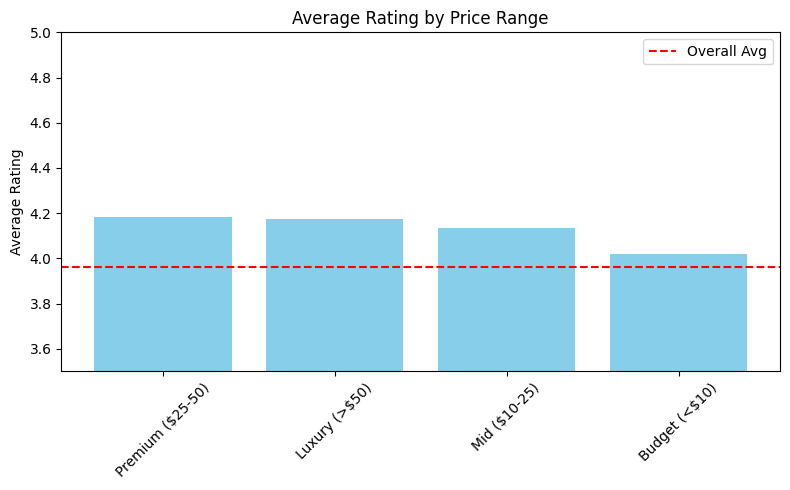

In [14]:
import matplotlib.pyplot as plt

q4_pdf = q4_result.toPandas()

plt.figure(figsize=(8, 5))

plt.bar(q4_pdf["price_range"], q4_pdf["avg_customer_rating"], color='skyblue')
plt.title("Average Rating by Price Range")
plt.ylabel("Average Rating")
plt.ylim(3.5, 5.0)

overall_avg = reviews_df.select(avg("rating")).collect()[0][0]
plt.axhline(y=overall_avg, color='red', linestyle='--', label='Overall Avg')

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Business question provides insight into product quality, customer satisfaction, and assortment effectiveness across price segments

High average ratings in high-end segments indicate that premium/luxury products meet customer expectations.

Identifying segments with a large number of products and high satisfaction helps plan promotional campaigns.

For example, the Mid ($10–25) segment has many products and an average rating, so it can be promoted as “the best balance of price and quality.”

## Q5: Top Reviewers vs Overall Average (JOIN)

In [15]:
print("Compare users with 20+ reviews vs overall average\n")

# calculate overall average
overall_avg = reviews_df.select(avg("rating")).collect()[0][0]
print(f"Overall category average rating: {overall_avg:.3f}\n")

# find power reviewers
power_reviewers = reviews_df.groupBy("user_id") \
    .agg(
        count("*").alias("review_count"),
        avg("rating").alias("avg_rating"),
        avg("helpful_vote").alias("avg_helpful"),
        countDistinct("parent_asin").alias("unique_products")
    ) \
    .filter(col("review_count") >= 20) \
    .withColumn("vs_overall", col("avg_rating") - overall_avg) \
    .orderBy(col("review_count").desc())

print(f"Found {power_reviewers.count()} power reviewers (20+ reviews)\n")

# show top 20
power_reviewers.show(20, truncate=False)

Compare users with 20+ reviews vs overall average

Overall category average rating: 3.961

Found 115 power reviewers (20+ reviews)

+------------------------------+------------+------------------+-------------------+---------------+---------------------+
|user_id                       |review_count|avg_rating        |avg_helpful        |unique_products|vs_overall           |
+------------------------------+------------+------------------+-------------------+---------------+---------------------+
|AG73BVBKUOH22USSFJA5ZWL7AKXA  |165         |4.533333333333333 |0.3151515151515151 |164            |0.5724741558010247   |
|AEZP6Z2C5AVQDZAJECQYZWQRNG3Q  |146         |4.13013698630137  |0.0821917808219178 |145            |0.16927780876906118  |
|AEMP3A7IKW37CMWFXNKXWW6HGJHA_1|115         |3.973913043478261 |0.7565217391304347 |115            |0.01305386594595248  |
|AGZUJTI7A3JFKB4FP5JOH6NVAJIQ_1|87          |4.724137931034483 |0.27586206896551724|87             |0.7632787535021746   |
|AFDYIK

These are users who have left ≥20 reviews (power reviewers). The vs_overall column shows how much their average rating differs from the overall average (≈3.96).

A high average rating for power reviewers can drive sales if their reviews are publicly displayed on the site.

Rigorous power reviewers can help identify product flaws and improve the quality of goods/services.

## Q6: Monthly Rating Trends (GROUP BY)

In [19]:
print("\nSample timestamps from dataset:")
reviews_df.select("timestamp").show(10, truncate=False)


Sample timestamps from dataset:
+-------------+
|timestamp    |
+-------------+
|1396134374000|
|1666586741918|
|1571068519970|
|1405934317000|
|1294753527000|
|1423438116000|
|1604556522660|
|1595775425518|
|1632591717374|
|1602253264442|
+-------------+
only showing top 10 rows



In [20]:
print("\nChecking date range in dataset...")

date_range = reviews_df.select(
    from_unixtime(col("timestamp") / 1000).alias("date")
).agg(
    min("date").alias("oldest"),
    max("date").alias("newest")
).collect()[0]

print(f"  Oldest review: {date_range['oldest']}")
print(f"  Newest review: {date_range['newest']}")

newest_date = datetime.strptime(date_range['newest'][:19], "%Y-%m-%d %H:%M:%S")
two_years_ago = newest_date - timedelta(days=730)

print(f"\nAnalyzing period: {two_years_ago.date()} to {newest_date.date()}")


Checking date range in dataset...
  Oldest review: 2000-11-01 06:24:18
  Newest review: 2023-09-09 03:39:36

Analyzing period: 2021-09-09 to 2023-09-09


In [21]:
two_years_ago_ms = int(two_years_ago.timestamp() * 1000)

print(f"  Timestamp threshold (ms): {two_years_ago_ms}")

q6_result = reviews_df.filter(col("timestamp") >= two_years_ago_ms) \
    .withColumn("review_date", from_unixtime(col("timestamp") / 1000)) \
    .withColumn("year_month", date_format("review_date", "yyyy-MM")) \
    .groupBy("year_month") \
    .agg(
        avg("rating").alias("avg_rating"),
        count("*").alias("review_count"),
        sum(when(col("verified_purchase") == True, 1).otherwise(0)).alias("verified_count")
    ) \
    .withColumn("verified_percentage", (col("verified_count") / col("review_count")) * 100) \
    .orderBy("year_month")

q6_result.show(24)

  Timestamp threshold (ms): 1631147976000
+----------+------------------+------------+--------------+-------------------+
|year_month|        avg_rating|review_count|verified_count|verified_percentage|
+----------+------------------+------------+--------------+-------------------+
|   2021-09|3.6239563809848354|        5869|          5301|  90.32203101039359|
|   2021-10| 3.605213210173352|        7903|          7123|   90.1303302543338|
|   2021-11| 3.619397277038397|        6537|          5934|  90.77558513079394|
|   2021-12|3.6332200384217526|        6767|          6208|  91.73932318604994|
|   2022-01|3.6839602248162557|        6939|          6388|  92.05937454964692|
|   2022-02|3.6082983001279474|        5471|          5024|   91.8296472308536|
|   2022-03|3.6945316372046917|        6053|          5541|  91.54138443746902|
|   2022-04| 3.701286416950435|        5286|          4789|  90.59780552402573|
|   2022-05|3.7644382911392404|        5056|          4609|  91.15901898734177

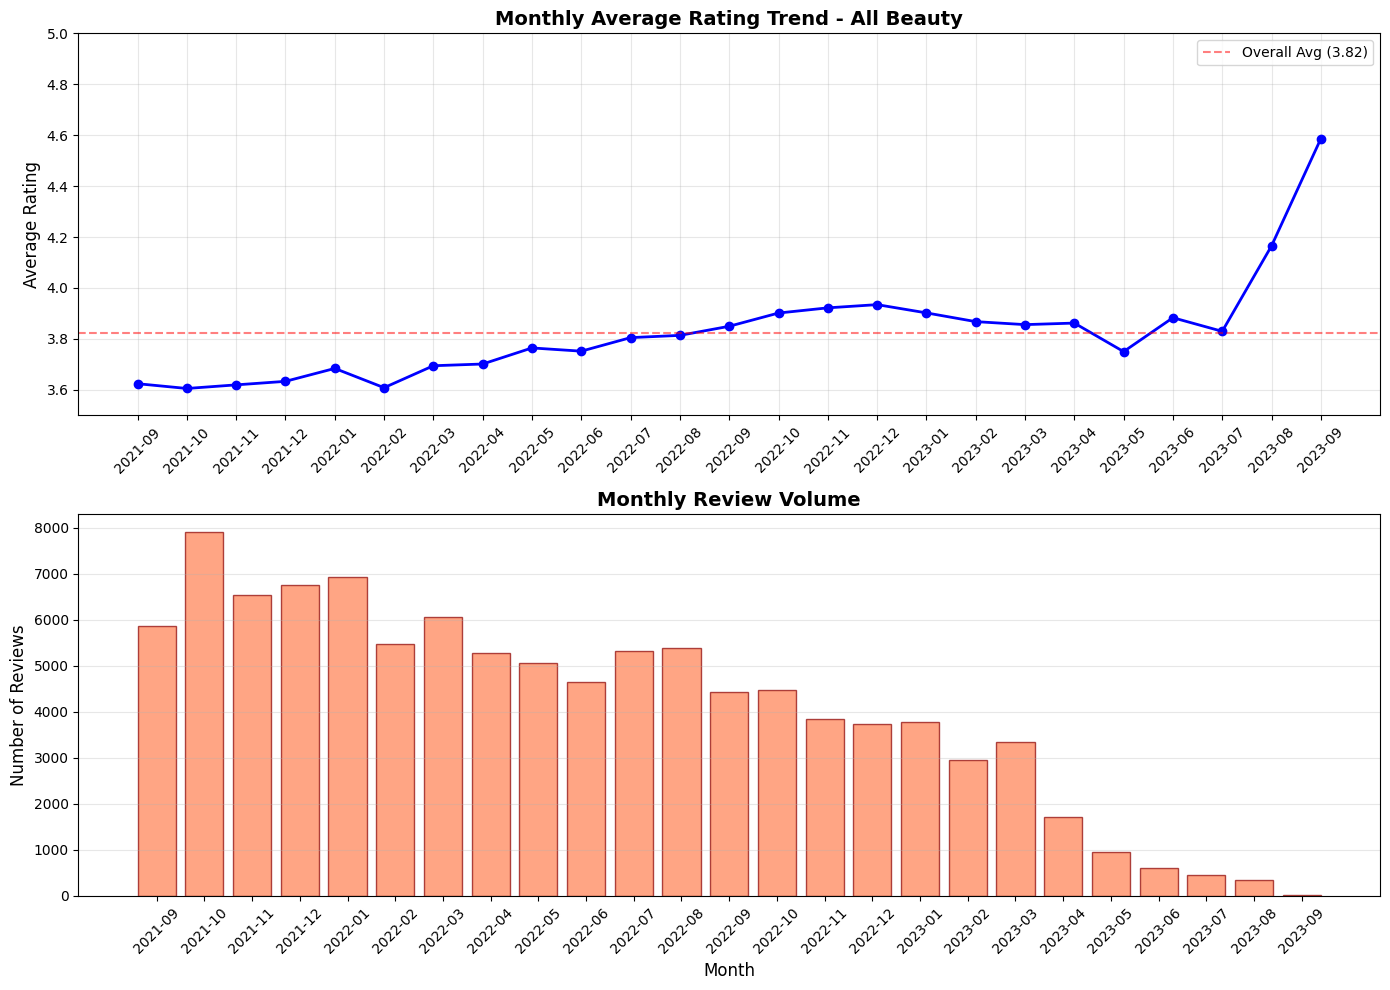

In [22]:
q6_pdf = q6_result.toPandas()
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
# Chart 1: Average rating trend
axes[0].plot(q6_pdf["year_month"], q6_pdf["avg_rating"], 
      marker='o', linewidth=2, color='blue', markersize=6)
axes[0].set_title("Monthly Average Rating Trend - All Beauty", 
      fontsize=14, fontweight='bold')
axes[0].set_ylabel("Average Rating", fontsize=12)
axes[0].set_ylim(3.5, 5.0)
axes[0].axhline(y=q6_pdf["avg_rating"].mean(), 
      color='red', linestyle='--', alpha=0.5, 
      label=f'Overall Avg ({q6_pdf["avg_rating"].mean():.2f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)
    
# Chart 2: Review volume
axes[1].bar(q6_pdf["year_month"], q6_pdf["review_count"], 
      color='coral', alpha=0.7, edgecolor='darkred')
axes[1].set_title("Monthly Review Volume", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Number of Reviews", fontsize=12)
axes[1].set_xlabel("Month", fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.show()

There has been a gradual increase in the rating since late 2022, which may indicate improved product quality or changes in buyers/reviews.

Some months have over 7,000 reviews, others less than 400. This may be a seasonal effect or related to the number of active buyers.

Recent months have >95% verified purchases, which adds credibility to the rating.

Track user satisfaction trends over time and respond to rating drops in a timely manner.

Also useful for marketing campaigns, inventory planning, and identifying seasonal effects in reviews.

## Q7: Running Average Rating Over Time (WINDOW FUNCTION)

In [29]:
product_reviews = reviews_df.groupBy("parent_asin") \
    .agg(count("*").alias("review_count"))

top_products = product_reviews.orderBy(col("review_count").desc()) \
    .limit(3) \
    .select("parent_asin") \
    .rdd.flatMap(lambda x: x).collect()

print(f"Top 3 products by review count: {top_products}")

Top 3 products by review count: ['B085BB7B1M', 'B0BM4GX6TT', 'B07C533XCW']


In [33]:
print("Window function: AVG(rating) OVER (PARTITION BY product ORDER BY timestamp)\n")

window_spec_time = Window.partitionBy("parent_asin") \
    .orderBy("timestamp") \
    .rowsBetween(Window.unboundedPreceding, Window.currentRow)

q9_result = reviews_df.filter(col("parent_asin").isin(top_products)) \
    .withColumn("running_avg", avg("rating").over(window_spec_time)) \
    .withColumn("review_date", from_unixtime(col("timestamp") / 1000)) \
    .withColumn("review_number", row_number().over(
        Window.partitionBy("parent_asin").orderBy("timestamp")
    )) \
    .join(
        metadata_df.select("parent_asin"),
        "parent_asin"
    ).select(
        "parent_asin",
        "review_number",
        "review_date",
        "rating",
        "running_avg"
    ).orderBy("parent_asin", "review_number")

print("Sample of running averages:\n")
q9_result.filter(col("review_number") % 50 == 0).show(20, truncate=50)

Window function: AVG(rating) OVER (PARTITION BY product ORDER BY timestamp)

Sample of running averages:

+-----------+-------------+-------------------+------+-----------------+
|parent_asin|review_number|        review_date|rating|      running_avg|
+-----------+-------------+-------------------+------+-----------------+
| B07C533XCW|           50|2018-10-09 06:24:07|   4.0|             4.44|
| B07C533XCW|          100|2018-11-20 06:11:48|   4.0|             4.65|
| B07C533XCW|          150|2018-12-29 07:30:31|   5.0|4.653333333333333|
| B07C533XCW|          200|2019-01-27 19:09:07|   4.0|             4.63|
| B07C533XCW|          250|2019-03-02 15:12:52|   5.0|            4.524|
| B07C533XCW|          300|2019-04-03 22:07:00|   4.0|4.553333333333334|
| B07C533XCW|          350|2019-04-28 11:27:07|   5.0|             4.52|
| B07C533XCW|          400|2019-05-26 00:07:13|   5.0|           4.4825|
| B07C533XCW|          450|2019-06-16 03:20:39|   5.0|4.448888888888889|
| B07C533XCW|     

In [34]:
metadata_alias = metadata_df.select(
    col("parent_asin"),
    col("title").alias("product_title") 
)

q9_result = reviews_df.filter(col("parent_asin").isin(top_products)) \
    .withColumn("running_avg", avg("rating").over(window_spec_time)) \
    .withColumn("review_date", from_unixtime(col("timestamp") / 1000)) \
    .withColumn("review_number", row_number().over(
        Window.partitionBy("parent_asin").orderBy("timestamp")
    )) \
    .join(
        metadata_alias,
        "parent_asin",
        "left"
    ).select(
        "parent_asin",
        "product_title",  
        "review_number",
        "review_date",
        "rating",
        "running_avg"
    ).orderBy("parent_asin", "review_number")

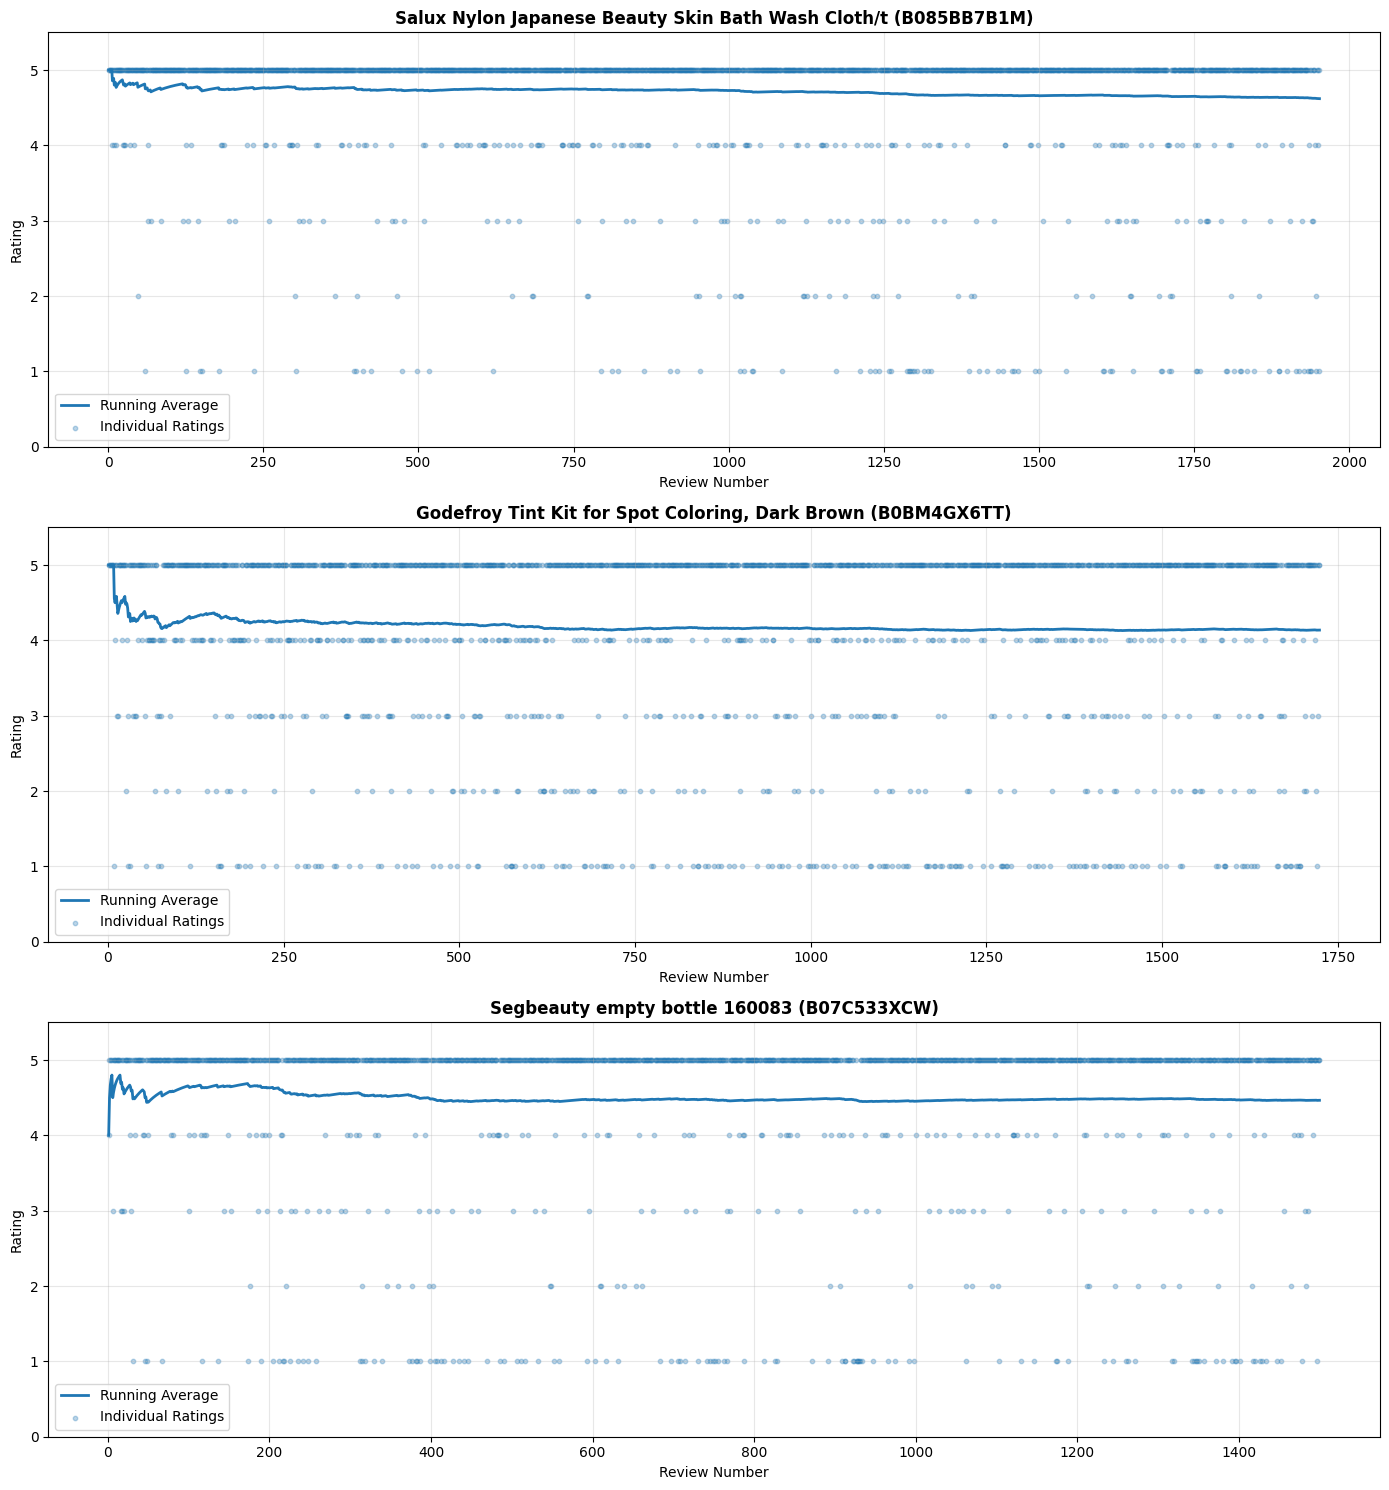

In [35]:
q9_pdf = q9_result.toPandas()

fig, axes = plt.subplots(len(top_products), 1, figsize=(14, 5*len(top_products)))
if len(top_products) == 1:
    axes = [axes]

for idx, product_id in enumerate(top_products):
    product_data = q9_pdf[q9_pdf["parent_asin"] == product_id]
    product_title = product_data["product_title"].iloc[0][:50]  # перші 50 символів
    
    axes[idx].plot(product_data["review_number"], product_data["running_avg"], 
                   linewidth=2, label='Running Average')
    axes[idx].scatter(product_data["review_number"], product_data["rating"], 
                      alpha=0.3, s=10, label='Individual Ratings')
    axes[idx].set_title(f"{product_title} ({product_id})", fontweight='bold')
    axes[idx].set_xlabel("Review Number")
    axes[idx].set_ylabel("Rating")
    axes[idx].set_ylim(0, 5.5)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

For each product, we see a trend in the rating over time.

We can observe:

1. Products that gradually get better ratings.

2. Products that drop in rating after initial launch.

3. Rating fluctuations due to individual critical reviews.

For businesses, this provides a deeper understanding of customer satisfaction over time, not just an average value.

This analytics allows you to not just know the average rating, but to see the dynamics of user satisfaction as reviews are received.

## Q8: Top Products by Review Volume per Price Segment

In [36]:
print("Window function: RANK() OVER (PARTITION BY price_range ORDER BY review_count)\n")

product_reviews = reviews_df.groupBy("parent_asin") \
    .agg(
        count("*").alias("review_count"),
        avg("rating").alias("avg_customer_rating")
    )

metadata_with_reviews = metadata_with_ranges.join(
    product_reviews,
    "parent_asin",
    "inner"
)
window_spec = Window.partitionBy("price_range").orderBy(col("review_count").desc())

q8_result = metadata_with_reviews.withColumn(
    "rank",
    rank().over(window_spec)
).filter(col("rank") <= 5).select(
    "price_range",
    "rank",
    "title",
    "price",
    "review_count",
    col("average_rating").alias("metadata_rating"),
    "avg_customer_rating",
    "store"
).orderBy("price_range", "rank")

print("Top 5 products in each price segment:\n")
q8_result.show(20, truncate=50)

Window function: RANK() OVER (PARTITION BY price_range ORDER BY review_count)

Top 5 products in each price segment:

+----------------+----+--------------------------------------------------+------+------------+---------------+-------------------+-------------+
|     price_range|rank|                                             title| price|review_count|metadata_rating|avg_customer_rating|        store|
+----------------+----+--------------------------------------------------+------+------------+---------------+-------------------+-------------+
|   Budget (<$10)|   1|Makone Crystal Crowns and Tiaras with Comb Head...|  9.99|        1362|            4.6| 4.4941262848751835|       Makone|
|   Budget (<$10)|   2|R-NEU 200 Cotton Rounds, 100% Natural Turkish C...|  6.99|         909|            4.6|  3.935093509350935|        R-NEU|
|   Budget (<$10)|   3|4 Point Eyebrow Pen, Micro Ink Tat Brow Pen Wat...|  7.99|         831|            3.7| 4.2755716004813475|Lunana Beauty|
|   Budget (

Helps to see which products are the most popular in each price segment.

For example, in the budget segment, these may be products that are sold in bulk, even if the rating is lower.

You can see whether customer reviews match the stated rating (metadata_rating vs avg_customer_rating).

If a product has many reviews but a low rating, you can consider the reasons for the decline in quality or problems with the product.